In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

2025-08-23 01:03:29.838608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755911009.996057      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755911010.040485      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TRAIN_DIR = "/kaggle/input/rice-disease-dataset/rice_disease_ds/train"
TEST_DIR = "/kaggle/input/rice-disease-dataset/rice_disease_ds/test"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
for class_name in os.listdir(TRAIN_DIR):
    path = os.path.join(TRAIN_DIR, class_name)
    print(f"Lớp {class_name} chứa: {len(os.listdir(path))}")

Lớp bacterial_leaf_blight chứa: 2859
Lớp brown_spot chứa: 2873
Lớp blast chứa: 2907
Lớp healthy chứa: 1923


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 10562 files belonging to 4 classes.
Using 8450 files for training.


I0000 00:00:1755911112.508084      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 10562 files belonging to 4 classes.
Using 2112 files for validation.
Found 2642 files belonging to 4 classes.


In [5]:
def configure_ds(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

efficientnet_train = configure_ds(train_ds)
efficientnet_val   = configure_ds(val_ds)
efficientnet_test  = configure_ds(test_ds)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.05, 0.05),
])

In [7]:
def build_model(base_model, num_classes, preprocessing_layer, augmentation_layer):
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = augmentation_layer(inputs)
    x = preprocessing_layer(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [8]:
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
]

In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [10]:
efficientnet_base = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
efficientnet_model = build_model(efficientnet_base, num_classes, efficientnet_preprocess, data_augmentation)
efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
                           loss='sparse_categorical_crossentropy', metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(efficientnet_train, validation_data=efficientnet_val, epochs=50, callbacks=callbacks)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


E0000 00:00:1755911143.583651      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1755911166.069285     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


133/133 ━━━━━━━━━━━━━━━━━━━━ 69s 184ms/step - accuracy: 0.4355 - loss: 1.2223 - val_accuracy: 0.7841 - val_loss: 0.6069 - learning_rate: 1.0000e-04
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.7671 - loss: 0.6322 - val_accuracy: 0.8627 - val_loss: 0.3794 - learning_rate: 1.0000e-04
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.8287 - loss: 0.4568 - val_accuracy: 0.8741 - val_loss: 0.3251 - learning_rate: 1.0000e-04
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.8709 - loss: 0.3552 - val_accuracy: 0.8845 - val_loss: 0.2908 - learning_rate: 1.0000e-04
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.8895 - loss: 0.2983 - val_accuracy: 0.9025 - val_loss: 0.2483 - learning_rate: 1.0000e-04
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.8964 - loss: 0.2778 - val_accuracy: 0.9010 - val_loss: 0.2344 - learning_rate: 1.0000e-04
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - 

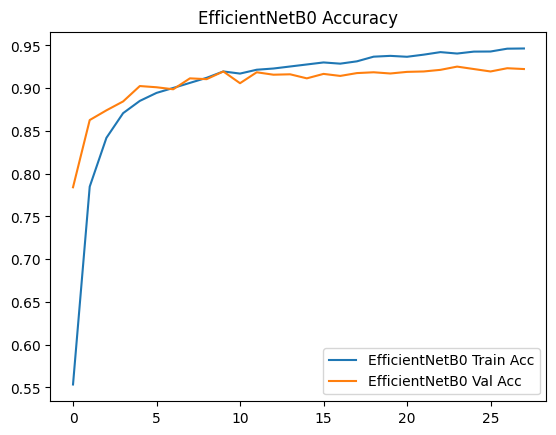

In [12]:
def plot_history(history, label):
    plt.plot(history.history['accuracy'], label=f'{label} Train Acc')
    plt.plot(history.history['val_accuracy'], label=f'{label} Val Acc')
    plt.title(f'{label} Accuracy')
    plt.legend()
    plt.show()

plot_history(efficientnet_history, 'EfficientNetB0')

In [13]:
efficientnet_model.save("efficientnet_model.keras")

In [14]:
from tensorflow.keras.models import load_model

efficientnet_model_path = "/kaggle/working/efficientnet_model.keras"

efficientnet_model = load_model(efficientnet_model_path)

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

IMAGE_SIZE = (224, 224)

def predict_image(model, img_path, class_names, preprocess_func, model_name="Model"):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)

    plt.imshow(img_array.astype("uint8"))
    plt.axis("off")
    plt.title(f"Input Image for {model_name}")
    plt.show()

    img_preprocessed = preprocess_func(img_array)
    img_expanded = np.expand_dims(img_preprocessed, axis=0)  

    predictions = model.predict(img_expanded)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    print(f"[{model_name}] Predicted class: {predicted_class} (confidence: {confidence:.2f})\n")
    return predicted_class, confidence

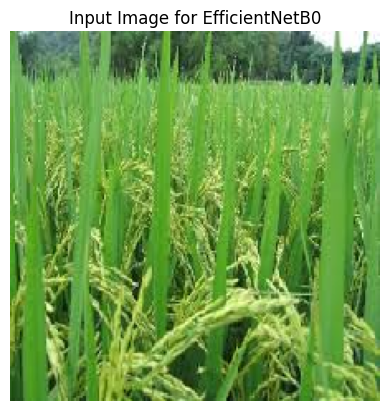

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[EfficientNetB0] Predicted class: healthy (confidence: 1.00)



('healthy', 0.99919397)

In [19]:
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

img_path = "/kaggle/input/test-img2/img_test/4.jpg"  

predict_image(efficientnet_model, img_path, class_names, efficientnet_preprocess, model_name="EfficientNetB0")